## Explore artifacts through the Client API

This notebook shows how to easily retrieve the artifacts produced by a Flow run (model, dataset, etc.), and provides some convenient functions to display and explore the original dataset and embedding space.

### Imports and global vars

First, let's make sure we are using the virtual environment with the project dependencies...

In [1]:
import sys
sys.executable

'/Users/jacopotagliabue/Documents/repos/metaflow-beginner-recsys-tutorial/venv/bin/python'

Now import the packages we need

In [2]:
from metaflow import Flow
import numpy as np
from random import choice
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.manifold import TSNE
import powerlaw

Define some config / global variables

In [3]:
FLOW_NAME = 'PlaylistRecsFlow'
LOCAL_METAFLOW = True

In [4]:
if LOCAL_METAFLOW:
    print("Local Metadata for Metaflow Selected - this is a global conf!")
    from metaflow import get_metadata, metadata
    # Set the metadata provider as the src folder in the project,
    # which contains /.metaflow
    metadata('../src')
    # Fetch currently configured metadata provider - check it's local!
    print(get_metadata())

Local Metadata for Metaflow Selected - this is a global conf!
local@../src


### Get artifacts from latest successful run

In [5]:
def get_latest_successful_run(flow_name: str):
    "Gets the latest successfull run."
    for r in Flow(flow_name).runs():
        if r.successful: 
            return r

In [6]:
latest_run = get_latest_successful_run(FLOW_NAME)
latest_model = latest_run.data.final_vectors
latest_dataset = latest_run.data.final_dataset

Check all is in order by printing out some stuff

In [7]:
latest_dataset.head(3)

,playlist_id,artist_sequence,track_sequence,track_test_x,track_test_y,predictions,hit
106262,5020b69b2434acf541d854e8e8e1ae4b-Rock,"[Paramore, Arctic Monkeys, Kings Of Leon, Foo ...","[Paramore|||Ain't It Fun, Arctic Monkeys|||Ara...","[Paramore|||Ain't It Fun, Arctic Monkeys|||Ara...",Kasabian|||stevie,"[Kasabian|||bumblebeee, Jamie T|||Zombie, The ...",1
160753,c040b6368c587949b2c719653d2de8b8-shower tunes,"[Beyoncé, All Time Low, Fall Out Boy, One Dire...","[Beyoncé|||7/11, All Time Low|||A Love Like Wa...","[Beyoncé|||7/11, All Time Low|||A Love Like Wa...",Little Mix|||Wings,"[Fall Out Boy|||Young Volcanoes, Anarbor|||Wha...",0
35242,e74064134220c4cd8356434ab356a790-Sade - The Ul...,"[Sade, Sade, Sade, Sade, Sade, Sade, Sade, Sad...","[Sade|||Babyfather - Remastered Version, Sade|...","[Sade|||Babyfather - Remastered Version, Sade|...",Sade|||Your Love Is King - Remastered,"[Sade|||The Sweetest Taboo, Sade|||The Moon an...",0


In [8]:
len(latest_dataset)

16372

In [9]:
print("# track vectors in the space: {}".format(len(latest_model)))

# track vectors in the space: 447522


In [10]:
test_track = choice(list(latest_model.index_to_key))
print("Example track: '{}'".format(test_track))
test_vector = latest_model[test_track]
print("Test vector for '{}': {}".format(test_track, test_vector[:5]))
test_sims = latest_model.most_similar(test_track, topn=3)
print("Similar songs to '{}': {}".format(test_track, test_sims))

Example track: 'Fred V & Grafix|||Forest Fires'
Test vector for 'Fred V & Grafix|||Forest Fires': [-0.0077608  -0.66371936  0.15772577  0.20691971 -0.18309085]
Similar songs to 'Fred V & Grafix|||Forest Fires': [('Rachel Row|||Follow The Step - Justin Martin Remix', 0.9652296304702759), ('Atlantic Connection|||Fourzero41', 0.9624707102775574), ('Kove|||Gobble', 0.9622803330421448)]


### Explore the dataset

Let's visualize the distribution of tracks and artist in our dataset. 

In [11]:
def plot_distribution(artist_sequence, track_sequence, n_bins: int=50):
    """
    Plot distributions of tracks and artists in the final dataset.
    
    Note that artist_sequence and track_sequence are two columns from a DF,
    and each row is a sequence of artists/tracks in a playlist (i.e. each row 
    is a playlist).
    """
    # unnest lists of lists as a list
    artists  = [item for sublist in artist_sequence for item in sublist]
    songs = [item for sublist in track_sequence for item in sublist]
    # debug print
    # print(songs[:20], artists[:20])
    # plot counts
    artist_counter = Counter(artists)
    song_counter = Counter(songs)
    print("\nTop artists: {}\n".format(artist_counter.most_common(20)))
    print("\nTop songs: {}\n".format(song_counter.most_common(20)))
    fig, axs = plt.subplots(1, 2, tight_layout=True)
    axs[0].hist(artist_counter.values(), bins=n_bins)
    axs[1].hist(song_counter.values(), bins=n_bins)
    plt.show()
    
    return artist_counter, song_counter


Top artists: [('The Rolling Stones', 3598), ('Coldplay', 3199), ('Radiohead', 2565), ('Daft Punk', 2562), ('Kanye West', 2439), ('Green Day', 2032), ('Eminem', 2014), ('Queen', 2004), ('JAY Z', 1911), ('Rihanna', 1884), ('Pearl Jam', 1819), ('David Guetta', 1759), ('Beyoncé', 1704), ('Madonna', 1665), ('U2', 1642), ('Bruce Springsteen', 1640), (None, 1632), ('Michael Jackson', 1613), ('Muse', 1612), ('David Bowie', 1590)]


Top songs: [('M83|||Midnight City', 204), ('Imagine Dragons|||Radioactive', 183), ('Avicii|||Wake Me Up', 176), ('The Lumineers|||Ho Hey', 169), ('Daft Punk|||Get Lucky - Radio Edit', 162), ('Of Monsters and Men|||Little Talks', 161), ('Lorde|||Royals', 159), ("Macklemore & Ryan Lewis|||Can't Hold Us - feat. Ray Dalton", 156), ('Bastille|||Pompeii', 156), ('Robin Thicke|||Blurred Lines', 148), ('Arctic Monkeys|||Do I Wanna Know?', 147), ('Gotye|||Somebody That I Used To Know', 146), ('Foster The People|||Pumped up Kicks', 139), ('Fun.|||We Are Young (feat. Janelle 

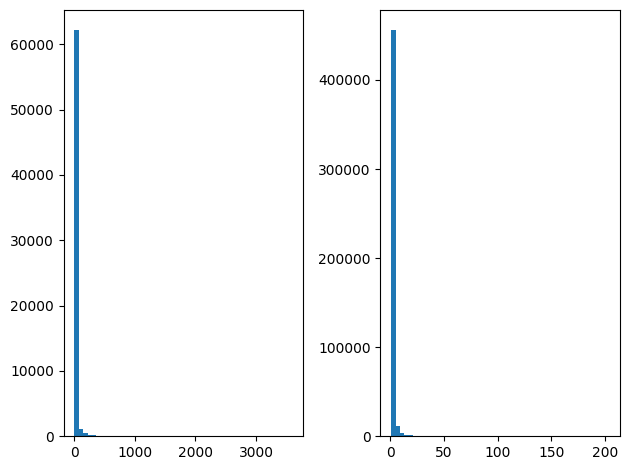

In [12]:
artist_counter, song_counter = plot_distribution(
    latest_dataset['artist_sequence'], 
    latest_dataset['track_sequence'])

_BONUS: It looks like it's veeery skewed: if we want to get fancy, we can use the powerlaw library and formally compare the distribution to a powerlaw..._

Calculating best minimal value for power law fit


<AxesSubplot: >

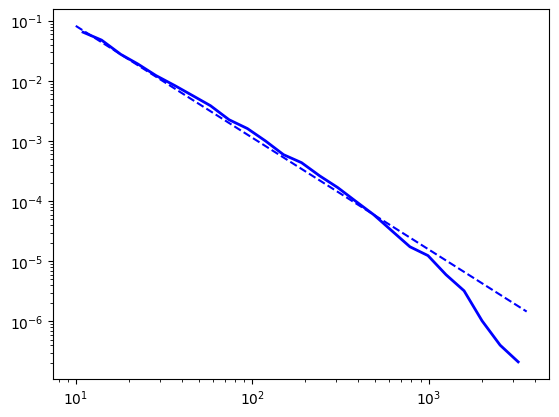

In [13]:
data = list(artist_counter.values())
fit = powerlaw.Fit(data, discrete=True)
figCCDF = fit.plot_pdf(color='b', linewidth=2)
fit.power_law.plot_pdf(color='b', linestyle='--', ax=figCCDF)

### Explore the model

The skip-gram model we trained is an embedding space: if we did our job correctly, the space is such that tracks closer in the space are actually similar, and tracks that are far apart are pretty unrelated.

Judging the quality of "fantastic embeddings" is hard (see https://arxiv.org/abs/2007.14906), but we point here to some common qualitative checks you can run.

In [14]:
# qualitative check, make sure to change with a song that is in the set
test_track = 'Daft Punk|||Get Lucky - Radio Edit'
test_sims = latest_model.most_similar(test_track, topn=3)
print("Similar songs to '{}': {}".format(test_track, test_sims))

Similar songs to 'Daft Punk|||Get Lucky - Radio Edit': [('Daft Punk|||Get Lucky', 0.9095422625541687), ('Robin Thicke|||Blurred Lines', 0.791029691696167), ('Pharrell Williams|||Happy', 0.7698039412498474)]


If you use 'Daft Punk|||Get Lucky - Radio Edit' as the query item in the space, you will discover a pretty interesting phenomenon, that is, that there are unfortunately many duplicates in the datasets, that is, songs which are technically different but semantically the same, i.e. Daft Punk|||Get Lucky - Radio Edit vs Daft Punk|||Get Lucky.

This is a problem as i) working with dirty data may be misleading, and ii) these issues make data sparsity worse, so the task for our model is now harder. That said, it is cool that typically KNN in the vector space can be used to quickly identify / remove duplicates, if you wish to do so.

First, let's map some tracks to known categories: the intuition is that songs that are similar will be colored in the same way in the chart, and so we will expect them to be close in the embedding space.

In [15]:
# we downsample the vector space a bit to the K most common songs to avoid crowding the plot / analysis
TOP_N_TRACKS = 2000
top_tracks = [_[0] for _ in song_counter.most_common(TOP_N_TRACKS)]
tracks = [_ for _ in latest_model.index_to_key if _ in top_tracks]

assert TOP_N_TRACKS == len(tracks)

In [16]:
# 0 is the generic "unnamed" category
tracks_to_category = {t: 'unknown' for t in tracks}

In [23]:
# we tag songs based on keywords found in the playlist name
# of course, better heuristics are possible ;-)
all_playlists_names = set(latest_dataset['playlist_id'].apply(lambda r: r.split('-')[1].lower().strip()))
# debug 
# print(all_playlists_names)
target_categories = [
    'rock',
    'rap',
    'classic',
]

In [24]:
# while not pretty, this select the playlists with the target keyword, and mark the tracks
# as belonging to that category

def tag_tracks_with_category(_df, target_word, tracks_to_category):
    _df = _df[_df['playlist_id'].str.contains(target_word)]
    # debug
    print(len(_df))
    # unnest the list
    songs = [item for sublist in _df['track_sequence'] for item in sublist]
    for song in songs:
        if song in tracks_to_category and tracks_to_category[song] == 'unknown':
            tracks_to_category[song] = target_word
    
    return tracks_to_category


for cat in target_categories:
    print("Processing {}".format(cat))
    tracks_to_category = tag_tracks_with_category(latest_dataset, cat, tracks_to_category)

Processing rock
43
Processing rap
62
Processing classic
9


Note: _to visualize a n-dimensional space, we first need to bring it to 2D (https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)_ 

In [25]:
def tsne_analysis(embeddings, perplexity=50, n_iter=1000):
    """
    TSNE dimensionality reduction of track embeddings - it may take a while!
    """
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter, verbose=1)
    return tsne.fit_transform(embeddings)

In [26]:
# extract the vectors from the model and project them in 2D
embeddings = np.array([latest_model[t] for t in tracks])
# debug, print out embedding shape
print(embeddings.shape)
tsne_results = tsne_analysis(embeddings)
assert len(tsne_results) == len(tracks)

(2000, 48)
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.088s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 7.597804


/Users/jacopotagliabue/Documents/repos/metaflow-beginner-recsys-tutorial/venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/jacopotagliabue/Documents/repos/metaflow-beginner-recsys-tutorial/venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.791000
[t-SNE] KL divergence after 1000 iterations: 1.450501


In [27]:
def plot_scatterplot_with_lookup(
    title: str, 
    items: list, 
    items_to_target_cat: dict,
    vectors: list):
    """
    Plot the 2-D vectors in the space, and use the mapping items_to_target_cat
    to color-code the points for convenience
    """
    
    groups = {}
    for item, target_cat in items_to_target_cat.items():
        if item not in items:
            continue

        item_idx = items.index(item)
        x = vectors[item_idx][0]
        y = vectors[item_idx][1]
        if target_cat in groups:
            groups[target_cat]['x'].append(x)
            groups[target_cat]['y'].append(y)
        else:
            groups[target_cat] = {
                'x': [x], 'y': [y]
                }
    
    fig, ax = plt.subplots(figsize=(10, 10))
    for group, data in groups.items():
        ax.scatter(data['x'], data['y'], 
                   alpha=0.1 if group == 'unknown' else 0.8, 
                   edgecolors='none', 
                   s=25, 
                   marker='o',
                   label=group)

    plt.title(title)
    plt.legend(loc=2)
    plt.show()
    
    return

Finally, we are ready to plot the latent space!

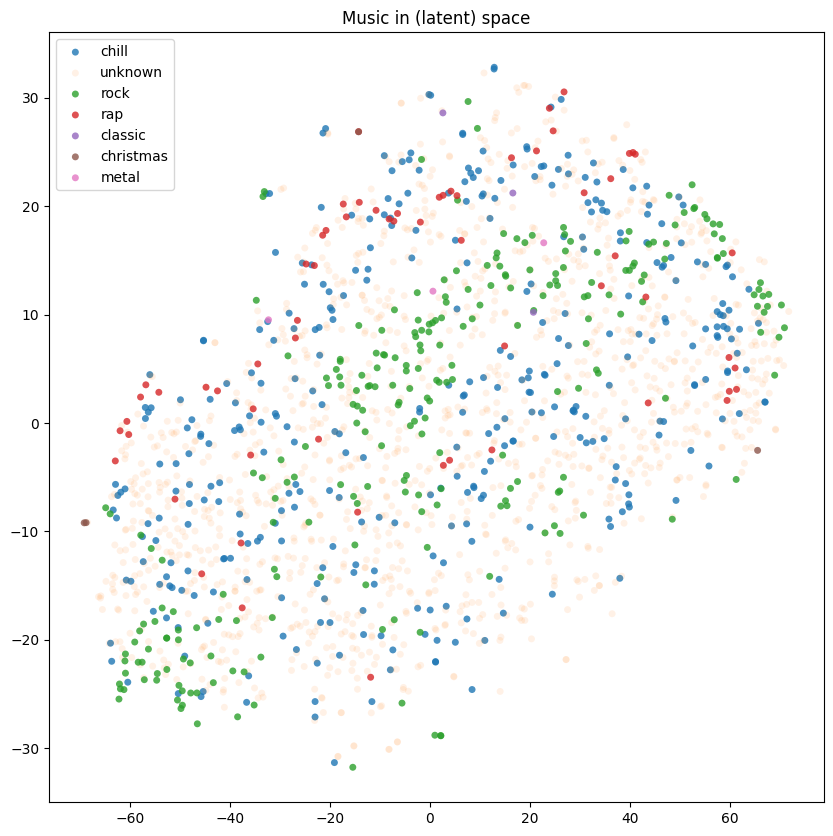

In [28]:
plot_scatterplot_with_lookup(
    'Music in (latent) space', 
    tracks, 
    tracks_to_category, 
    tsne_results)